In [62]:
### Simulation parameters
sigmabeta = 0.05
ngenes = 2000#23973
nsamples = 338
nsnps =  5000
ntrans = 1

In [63]:
#GX = np.random.normal(0, 1, ngenes * nsamples).reshape(ngenes, nsamples)
def read_expression(filename):
    gene_names = list()
    expression = list()
    with open(filename, 'r') as genefile:
        header = genefile.readline()
        donorids = header.strip().split("\t")[1:]
        for line in genefile:
            linesplit = line.strip().split("\t")
            expression.append(np.array(linesplit[1:], dtype=float))
            gene_names.append(linesplit[0])
    expression = np.array(expression)
    return donorids, expression, gene_names
_, expr, _ = read_expression("data/expressions/GTEx_wholeBlood_Normalzed_NoPEER_lmcorrected.txt")

print(expr.shape)
GX = expr[:ngenes, :]
#GX = expr / np.std(expr, axis = 1).reshape(-1,1)
#GX = np.random.normal(0, 1, ngenes * nsamples).reshape(ngenes, nsamples)
dosage, maf, _ = simulate.genotype(GX, 
                                   nsamples = nsamples, 
                                   ntrans = ntrans,
                                   nsnps = nsnps,
                                   sigmabeta = sigmabeta,
                                   ngenes = ngenes,
                                   cfrac = 0.01,
                                   fmin = 0.1,
                                   fmax = 0.5)

(23973, 338)


In [64]:
## Normalization with MAF
f = maf.reshape(-1, 1)
GT_normed = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
GT_centered = (dosage.T - np.mean(dosage.T,axis = 0)).T

    
sigmabeta2 = sigmabeta**2
sigmax2 = np.var(GT_centered.T,axis = 0)
Rscore, _ , _ , pvals_perm = regstat.rscore(GT_centered, GX, sigmabeta2, sigmax2)
Rscore_maf, S, W = regstat.rscore_maf(GT_normed, GX, sigmabeta2, 1)

In [65]:
pvals = regnull.pvals(S, Rscore_maf, sigmabeta2, 1)
pvals_maf = regnull.pvals(S, Rscore_maf, sigmabeta2, 1, corr=True, maf=maf, W = W)
# pvals_ultra = regnull.ultra_new_pvals(GT, Rscore, W, sigmabeta2, sigmax2)

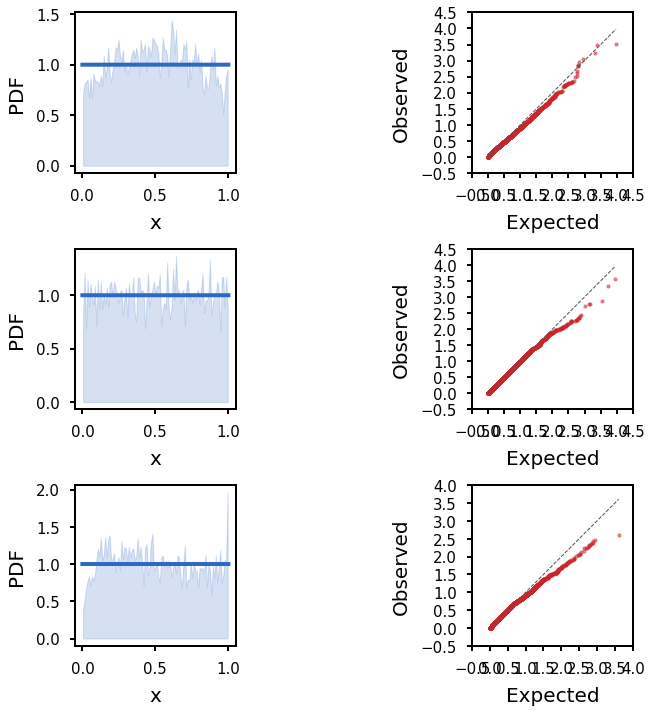

True transeqtls detected by MAF null: 0
True transeqtls detected by permuted null: 0


In [66]:
## Plot

fig = plt.figure(figsize = (12, 10))
#plt.suptitle("Binomial simulation / Binomial norm / Qnull new")
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

nbins = 100
sizefactor = 1
#hist_qq.plot(ax1, ax2, Y,     nbins, 'chi2', df = np.mean(df),     loc = 0, scale = 1, size = sizefactor)
#hist_qq.plot(ax3, ax4, Y_maf, nbins, 'chi2', df = np.mean(df_maf), loc = 0, scale = 1, size = sizefactor)
hist_qq.plot(ax1, ax2, pvals,     nbins, 'uniform', loc = 0, scale = 1, size = sizefactor)
hist_qq.plot(ax3, ax4, pvals_maf, nbins, 'uniform', loc = 0, scale = 1, size = sizefactor)
hist_qq.plot(ax5, ax6, pvals_perm, nbins, 'uniform', loc = 0, scale = 1, size = sizefactor)

plt.tight_layout()
plt.show()

#print(np.argsort(pvals_maf)[:1000])

print("True transeqtls detected by MAF null:", np.sum(np.argsort(pvals_maf)[:ntrans] > (nsnps - ntrans)))
print("True transeqtls detected by permuted null:", np.sum(np.argsort(pvals_perm)[:ntrans] > (nsnps - ntrans)))